## Monitoring data quality in third-party models from the AWS Marketplace

**Overview:**
A typical third-party model usage journey includes finding a model that works for you, you do a deep evaluation using your own ground truth dataset, and then deploy it in production. If the statistical nature of the data that your model receives while in production drifts away from the nature of the baseline data it was evaluated on, the model might begin to lose accuracy in its predictions. 

Amazon SageMaker's [Data quality monitoring](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-quality.html) automatically monitors machine learning (ML) models in production and notifies you when data quality issues arise.  Amazon SageMaker Model Monitor uses rules to detect data drift and alerts you when it happens. These alerts will help you understand whether you would need to re-evalute the ML model to see if it is still providing you the correct outputs. If it does not, you would need to request the third party seller to retrain and provide a new version of the AWS Marketplace model. 

In this notebook, you will learn how to perform Data Quality monitoring on a pre-trained third-party model from the AWS Marketplace.

**Contents:**
- Pre-requisites
- Step 1. Initial setup
    - 1.1 [Import packages and modules](#section_1_1)
    - 1.2 [Uploading sample datasets to your S3 bucket](#section_1_3)
- Step 2. Create and deploy the model endpoint with data capture
    - 2.1 [Create the model](#section_2_1)
    - 2.2 [Create the endpoint configuration with DataCapture](#section_2_2)
    - 2.3 [Create the model endpoint](#section_2_3)
    - 2.4 [Periodically check if the model's endpoint has changed from 'Creating' to 'InService'](#section_2_4)
- Step 3. Create a baselining job to suggest a set of baseline constraints
    - 3.1 [Create baselining job](#section_3_1)
- Step 4. Setup a monitoring schedule to monitor the data captured for the model's endpoint
    - 4.1 [Create a monitoring schedule](#section_4_1)
- Step 5. Invoking the inference endpoint with anomalous data
    - 5.1 [Initialize a Predictor to make prediction requests to the model's endpoint](#section_5_1)
    - 5.2 [Create a data quality constraint violations](#section_5_2)
- Step 6. Invoking the inference endpoint with anomalous data
    - 6.1 [Visualize the model monitor results](#section_6_1)
    - 6.2 [Run the SageMaker-Model-Monitor-Visualize.ipynb notebook](#section_6_2)

**Pre-requisites**

This notebook requires a subscription to the [Propensity-Planning to Buy a House](https://aws.amazon.com/marketplace/pp/prodview-vzofptk4lnxii) model, a pre-trained machine learning model package from AWS Marketplace.

1. Open the [Propensity-Planning to Buy a House](https://aws.amazon.com/marketplace/pp/prodview-vzofptk4lnxii) model in your browser. 

2. To subscribe to the model package, follow these steps: 
  1. Review the information available on the product details page including **Support Terms** .
  1. Click on **"Continue to Subscribe"**. You will now see the **"Subscribe to this software"** page. 
  1. Review **End User License Agreement** and **Pricing Terms**.
  1. **"Accept Offer"** button needs to be clicked if your organization agrees with EULA, pricing information and support terms.
  1. Once you click on **Continue to configuration** button and then choose a region, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3.  Copy the Model Package ARN and replace its contents in following cell. 
  
 
Note: 
Products with **Free Trials**, do not incur hourly software charges during free trial period, but AWS infrastructure charges still apply. Free Trials will automatically convert to a paid hourly subscription upon expiration. We have included steps below to cancel subscription at the end of this exercise. 


In [ ]:
#MODEL_PACKAGE_ARN=''
MODEL_PACKAGE_ARN = 'arn:aws:sagemaker:us-east-1:865070037744:model-package/planning-to-buy-house-basic-28fcb3ca751705854a7171b255d8ef43'  # Update as needed

<a id=section_1_1></a>
#### 1.1 Import packages and modules

In [ ]:
import boto3
import pandas as pd
import requests
import time
import io

from time import gmtime, strftime

from sagemaker import get_execution_role
from sagemaker import session
from sagemaker import ModelPackage

from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer

from sagemaker.model_monitor import CronExpressionGenerator
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.model_monitor import DataCaptureConfig


In [ ]:
# Get the execution role for the notebook instance.
role = get_execution_role()
session = session.Session()
s3_client = boto3.client('s3')
sm_client = boto3.client('sagemaker')
smr_client = boto3.client('sagemaker-runtime')

In [ ]:
# S3
BUCKET = session.default_bucket() # Update as needed
PREFIX = 'propensity-model-seller-name' # Update as needed


S3_DATA_CAPTURE_URI = 's3://{}/{}/datacapture'.format(BUCKET, PREFIX)
S3_BASELINE_DATASET_URI = 's3://{}/{}/train/{}'.format(BUCKET, PREFIX, 'baseline.csv')
S3_BASELINE_ANALYSIS_RESULTS_URI = 's3://{}/{}/baselining'.format(BUCKET, PREFIX)
S3_DATA_QUALITY_RPT_URI = 's3://{}/{}/reports'.format(BUCKET, PREFIX)

# Model
MODEL_NAME = 'propensity-model'
MODEL_ENDPOINT = 'propensity-model-endpoint'
MODEL_ENDPOINT_CONFIG = 'propensity-model-endpoint-config'
MODEL_BASELINE_JOB = 'propensity-model-baseline-job'
MODEL_MONITOR_SCHEDULE_NAME = 'propensity-model-data-quality-schedule'
MODEL_MONITOR_INSTANCE_TYPE = 'ml.m4.xlarge'
MODEL_INFERENCE_INSTANCE_TYPE = 'ml.m4.xlarge'
MODEL_INSTANCE_COUNT = 1
MODEL_BASELINE_JOB_NAME = '{}-{}'.format(MODEL_BASELINE_JOB, strftime("%Y-%m-%d-%H-%M-%S", gmtime()))



<a id=section_1_3></a>
#### 1.2 Uploading sample datasets to your S3 bucket

The baseline.csv and data_quality_drift.csv files are curated datasets I created by modifying the seller's [sample notebook](https://github.com/goprosper/prosper-sagemaker-basic-geo/blob/master/using_prosper_model_package_basic_geo.ipynb) to return high propensity and low propensity values (respectively) for generating a baseline_drift_check constraint violation.

Additionally, the data_quality_drift.csv file contains some rows with anomolous data that are used to demonstrate data_type_check and completeness_check constraint violations.

The baseline.csv file contains 29 columns and 301 rows with the first column as the target value (prediction)

The data_quality_drift.csv file contains 28 columns and 200 rows and is designed to illustrate a degredation in data quality from the baseline dataset.

In [ ]:
with open('../data/baseline.csv', "rb") as f:
    response=s3_client.upload_fileobj(f, BUCKET, '{}/train/{}'.format(PREFIX, 'baseline.csv'))
    response

In [ ]:
with open('../data/data_quality_drift.csv', "rb") as f:
    s3_client.upload_fileobj(f, BUCKET, '{}/train/{}'.format( PREFIX, 'data_quality_drift.csv'))

<a id=section_2_1></a>
#### 2.1 Create the model

Creates a model in Amazon SageMaker from a model package.

In [ ]:
#create a deployable model for damage inspection model package.
model = ModelPackage(role=role,
                      model_package_arn=MODEL_PACKAGE_ARN,
                      sagemaker_session=session)

<a id=section_2_2></a>
#### 2.2 Deploy model while enabling DataCapture

Creates an endpoint configuration that Amazon SageMaker hosting services uses to deploy models.

In [ ]:
%%time
data_capture_config = DataCaptureConfig(
                        enable_capture=True,
                        sampling_percentage=100,
                        destination_s3_uri=S3_DATA_CAPTURE_URI,
                        csv_content_types=["text/csv"])

#Deploy the model.
predictor = model.deploy(1, MODEL_INFERENCE_INSTANCE_TYPE, endpoint_name=MODEL_ENDPOINT,data_capture_config=data_capture_config)


<a id=section_3_1></a>
#### 3.1 Create a baselining job

The baseline calculations of statistics and constraints are needed as a standard against which data drift and other data quality issues can be detected. 

This job generates baseline statistics and suggests baseline constraints for the dataset and writes them to the output_s3_uri location that you specify.

In [ ]:
%%time
# Initializes a Monitor instance
default_model_monitor = DefaultModelMonitor(role=role,
                                            instance_count=MODEL_INSTANCE_COUNT,
                                            instance_type=MODEL_MONITOR_INSTANCE_TYPE)

# Suggest baselines for use with Amazon SageMaker Model Monitoring Schedules
job = default_model_monitor.suggest_baseline(
    job_name = MODEL_BASELINE_JOB_NAME,
    baseline_dataset=S3_BASELINE_DATASET_URI,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=S3_BASELINE_ANALYSIS_RESULTS_URI,
    wait=True,
    logs=False
)

<a id=section_4_1></a>
#### 4.1 Create a monitoring schedule

In this step, you create a schedule that regularly starts Amazon SageMaker Processing Jobs to monitor the data captured for an Amazon SageMaker Endoint.


Note: 
    Even for an hourly schedule, Amazon SageMaker has a buffer period of 20 minutes to schedule your execution. You might see your execution start anywhere between the first ~20 minutes after the hour boundary (i.e. 00:00 – 00:20). This is expected and done for load balancing on the backend.

In [ ]:
default_model_monitor.create_monitoring_schedule(
    monitor_schedule_name = MODEL_MONITOR_SCHEDULE_NAME,
    endpoint_input = MODEL_ENDPOINT,
    output_s3_uri = S3_DATA_QUALITY_RPT_URI,
    statistics = default_model_monitor.baseline_statistics(),
    constraints = default_model_monitor.suggested_constraints(),
    schedule_cron_expression = CronExpressionGenerator.hourly()
)

In [ ]:
# Allow time for processing
time.sleep(30)

# Print the current status
monitor_schedule_details = default_model_monitor.describe_schedule()['MonitoringScheduleStatus']
print('>> The current status of monitoring schedule "{0}" is {1}'.format(MODEL_MONITOR_SCHEDULE_NAME, monitor_schedule_details))

<a id=section_5_1></a>
#### 5.1 Initialize a Predictor

Make prediction requests to the model's endpoint. The Predictor object is used to invoke the model's real-time inference endpoint to make predictions based on sample data.

In [ ]:
# Create predictor endpoint
predictor = Predictor(endpoint_name=MODEL_ENDPOINT, 
                      sagemaker_session=None, 
                      serializer=CSVSerializer())   

In [ ]:
def predict(sample):
    if(len(sample) > 0):    
        return predictor.predict(data=sample).decode('utf-8')

<a id=section_5_2></a>
#### 5.2 Create data quality constraint violations

For this demo, we'll generate a couple of constraint violations (data_type_check, completeness_check, and baseline_drift_check) for Amazon SageMaker Model Monitor to detect.

Here's the structure of the data_quality_drift.csv file:

- Rows 1-10:  Samples with negative floating point values (instead of positive integers) in the 3rd and 4th columns
- Rows 11-20: Samples with missing values in the 2nd column
- Rows 20-200: Samples that yield a low propensity prediction that deviates from the baseline.

We'll use array slicing for accessing the anomolous sample data.

In [ ]:
# Convert to Dataframe
df = pd.read_csv('../data/data_quality_drift.csv', header=None, na_filter=False)

# List values by column to maintain the column dtype
samples = [df[x].values.tolist() for x in df.columns]

# Use unpacking operator * to unzip the data
samples = list(list(x) for x in zip(*samples))

Here we'll generate a data_type_check constraint violation

In [ ]:
# Invoke real-time inference endpoint 
for index, sample in enumerate(samples[0:10]):

    # Get inference response
    response = predict(sample)
    time.sleep(0.5)
    # Display the model's prediction probability
    print('Sample {0} >> Input: {1}: >> Prediction: {2}'.format(index, sample, response))

Now, let's generate a completeness_check constraint violation

In [ ]:
# Invoke real-time inference endpoint 
for index, sample in enumerate(samples[10:20]):

    # Get inference response
    response = predict(sample)
    time.sleep(0.5)
    # Display the model's prediction probability
    print('Sample {0} >> Input: {1}: >> Prediction: {2}'.format(index, sample, response))

Finally, we'll generate a baseline_drift_check constraint violation

In [ ]:
# Invoke real-time inference endpoint 
for index, sample in enumerate(samples[20:]):

    # Get inference response
    response = predict(sample)
    time.sleep(0.5)
    # Display the model's prediction probability
    print('Sample {0} >> Input: {1}: >> Prediction: {2}'.format(index, sample, response))

<a id=section_6_1></a>
#### 6.1 Visualize the model monitor results

After the monitoring schedule has ran the monitoring job, go to the Model Monitoring tab, double-click the monitoring job to view the monitoring job details. The Monitoring status of ‘Issue found’ indicates that the monitor successfully detected one or more data quality constraint violations created by the data drift datasets.

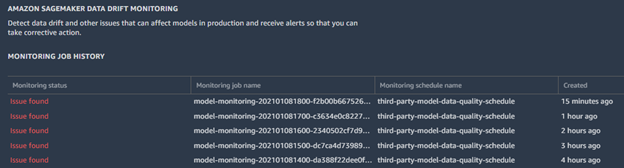

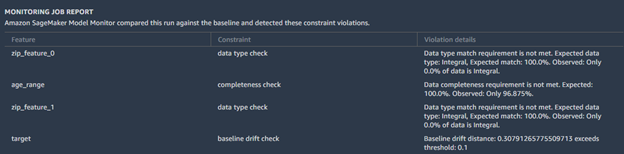

<a id=section_6_2></a>
#### 6.2 Run the SageMaker-Model-Monitor-Visualize.ipynb notebook

To graphically visualize the distribution and the distribution statistics for all features, SakeMaker includes a pre-built notebook for viewing feature statistics.

1. In the Monitoring Job Details tab, copy the full value for the Processing Job ARN to your clipboard
2. Select the View Amazon SageMaker notebook link
3. Select Import Notebook (in the upper-right section of the tab)
4. Select Kernel: Python 3 (Data Science), then choose the Select button. (It may take a few minutes for the Kernel to start)
5. After importing the SageMaker-Model-Monitor-Visualize.ipynb notebook, update the code cell that contains the variable processing_job_arn with the value from the Processing Job ARN in your clipboard.
6. Run all cells in the notebook to review the execution and baseline details from the model monitoring processing job.


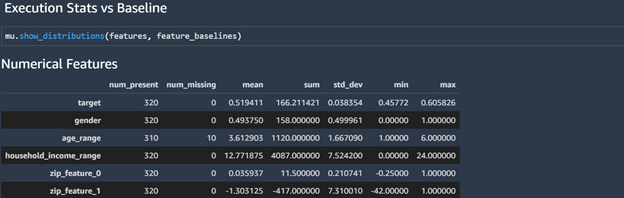

Bar chart illustrating the statistical data quality deviation between the baseline data and the data drift dataset

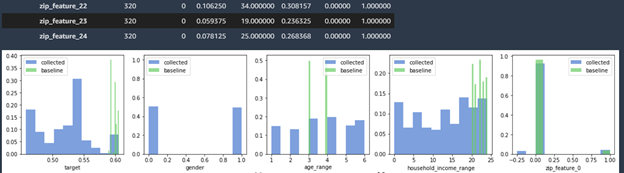

Inference feature statistics plotted against baseline feature statistics

#### Cleanup Resources

In [ ]:
'''
print('Stopping monitoring schedule...')
sm_client.stop_monitoring_schedule(MonitoringScheduleName=MODEL_MONITOR_SCHEDULE_NAME)
time.sleep(30) # allow time for processing
sm_client.delete_monitoring_schedule(MonitoringScheduleName=MODEL_MONITOR_SCHEDULE_NAME)
'''

In [ ]:
'''
model.sagemaker_session.delete_endpoint(MODEL_ENDPOINT)
model.sagemaker_session.delete_endpoint_config(MODEL_ENDPOINT_CONFIG)
model.delete_model()
'''

If you would like to unsubscribe to the model, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you would need to cancel subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

